In [1]:
import os
os.chdir("../")

import numpy as np
import matplotlib.pyplot as plt

from Black76 import Black76
from StochasticOptimisation import StochasticOptimisation
from implied_vol import black_iv

# I. Black-Scholes volatilité implicite

On cherche la solution d'équation
$$
H(\sigma, Z) = \mathbb{E}\left(S_0\exp\left\{-\dfrac{\sigma^2T}{2} + \sigma\sqrt{T}Z\right\} - e^{-rT}K\right)^+ - \mathrm{Call}^{\mathrm{mkt}}(K, T) = 0, \quad Z \sim \mathcal{N}(0, 1)
$$
par rapport à $\sigma$.

La méthode stochastique:
$$
\sigma_{n+1} = \sigma_{n} - \gamma_{n + 1}H(\sigma_n, Z_{n+1}), \quad Z_n \sim \mathcal{N}(0, 1) \quad i.i.d.
$$

On choisit la vitesse proposée dans le cours:
$$
\gamma_n = \dfrac{c}{n^\alpha}, \ \alpha \in (0.5, 1).
$$

In [98]:
r = 0.05
sigma = 0.2
K = 100
T = 1.5
S = 100
flag = 'c'

F = S * np.exp(r * T)

model = Black76(sigma, r)
call_price = model.vanilla_price(T=T, K=K, F=F, flag=flag) 
print(f'Call "market" price:', call_price, f"(sigma = {sigma})")

Call "market" price: 13.442904812585327 (sigma = 0.2)


In [99]:
# Newton's method for IV calculation
black_iv(call_price, T, K, F, r, flag, method='Newton')

0.20000000000000023

In [100]:


rng = np.random.default_rng(seed=42)
def generate_H(batch_size, sigma):
    Z = rng.normal(size=(batch_size,) + sigma.shape)
    call_payoff = np.maximum(0, S * np.exp(-0.5 * sigma**2 * T + sigma * np.sqrt(T) * Z) - np.exp(-r * T) * K)
    return call_payoff - call_price

In [103]:
def convergence_diagram(sigma_init, batch_size, n_steps, alpha):
    n_sample = 100
    def learning_rate(n, alpha=alpha, c=0.01):
        return c / n**alpha

    stoch_algo = StochasticOptimisation(
        theta_init=sigma_init * np.ones(n_sample)[None, :],
        generate_gradient=generate_H,
        learning_rate=learning_rate,
        batch_size=batch_size
    )

    thetas = stoch_algo.step(n_steps=n_steps, return_path=True).squeeze()

    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(thetas[:, 0], 'b', label='Stochastic algorithm path')

    ax[0].hlines(sigma, 0, n_steps, color='r', label='Implied volatility')
    ax[0].set_title('Convergence diagram')
    ax[0].legend()
    ax[0].grid()

    ax[1].hist(thetas[-1], bins=20, color='b', alpha=0.7, range=[np.quantile(thetas[-1], 0.05), np.quantile(thetas[-1], 0.95)])
    ax[1].grid()
    ax[1].set_title("Empirical distribution of $\sigma_N$")

## Gradient stochastique

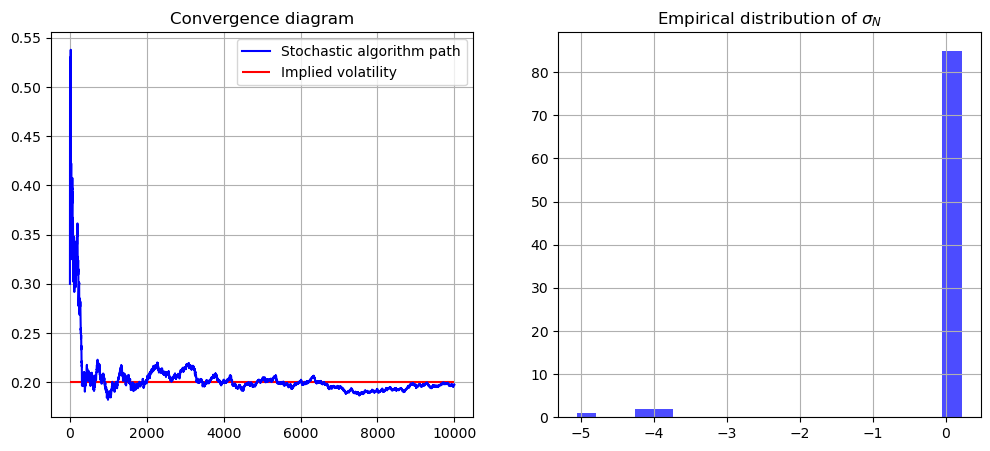

In [104]:
sigma_init = 0.3
batch_size = 1
n_steps = 10**4
alpha = 0.75

convergence_diagram(sigma_init, batch_size, n_steps, alpha)

## Gradient stochastique + minibatch
Minibatch diminue la variance et l'algorithm converge mieux.

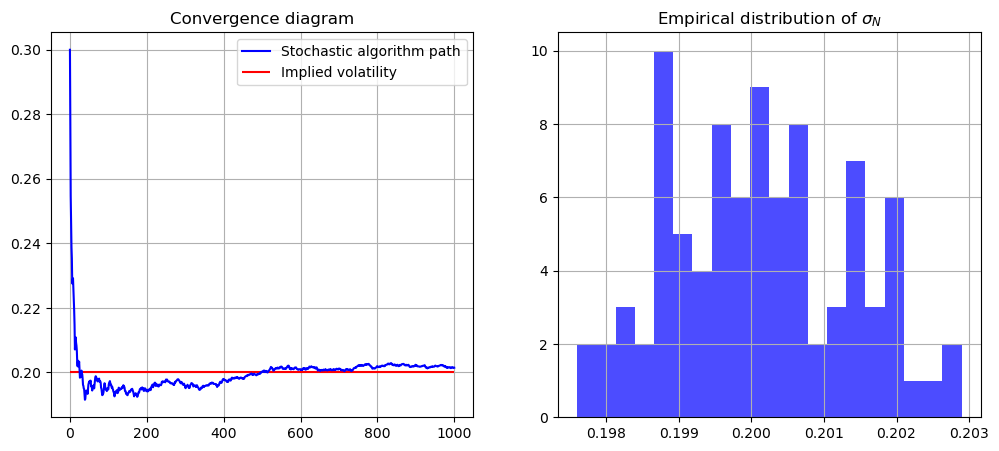

In [107]:
sigma_init = 0.3
batch_size = 100
n_steps = 10**3
alpha = 0.75

convergence_diagram(sigma_init, batch_size, n_steps, alpha)

# II. Correlation implicite

On suppose que les prix des actions satisfont
$$
S_t^i = S_0^i\exp\left\{\left(r - \dfrac{\sigma_i^2}{2}\right)t + \sigma_i W_t^i\right\}, \quad i = 1, 2
$$
où $W_t^1, W_t^2$ sont des mouvements browniens correlés avec la corrélation $\rho \in (-1, 1)$.

Option Best-of-Call:
$$
\mathrm{Payoff} = (\max(S_T^1, S_T^2) - K)^+
$$

On cherche la solution de 
$$
h(\rho) = \mathrm{BestOfCall}^{\mathrm{BS}}(\rho, S_0^1, S_0^2, K, T, r, \sigma_1, \sigma_2) - \mathrm{BestOfCall}^{\mathrm{Mkt}}(K, T) = 0
$$
en utilisant
$$
H(\rho, Z) = \left(\max\left(X_T^1(Z), X_T^2(Z)\right) - e^{-rT}K\right)^+ - \mathrm{BestOfCall}^{\mathrm{Mkt}}(K, T) , \quad Z \sim \mathcal{N}(0, I_2)
$$
où
$$
X_T^1(Z) = S_0^1\exp\left\{-\dfrac{\sigma_1^2T}{2} + \sigma_1\sqrt{T}Z_1\right\}, \\
X_T^2(Z) = S_0^2\exp\left\{-\dfrac{\sigma_2^2T}{2} + \sigma_2\sqrt{T}\left(\rho Z_1 + \sqrt{1 - \rho^2} Z_2\right)\right\}.
$$

On considère deux approches:
1. Projection de la correlation:
$$
\rho_{n+1} = \mathrm{Proj}_{[-1, 1]}(\rho_n - \gamma_{n+1}H(\rho_n, Z_{n+1})), \quad \rho_0 = 0.
$$
2. Arctan transformée: on pose $\rho_n(\theta) = \dfrac{2}{\pi}\arctan(\theta_n)$ et
$$
\theta_{n+1} = \theta_n - \gamma_{n+1}H(\rho_n(\theta), Z_{n+1}), \quad \theta_0 = 0.
$$

In [51]:
rho = 0.4

r = 0.05
sigma_1 = 0.15
sigma_2 = 0.2
T = 1.5
K = 100

S1_0 = 100
S2_0 = 100

In [52]:
rng = np.random.default_rng(seed=42)

def generate_payoff(batch_size, rho):
    Z = rng.normal(size=(batch_size, 2))
    X_1 = S1_0 * np.exp(-0.5 * sigma_1**2 * T + sigma_1 * np.sqrt(T) * Z[:, 0])
    X_2 = S2_0 * np.exp(-0.5 * sigma_2**2 * T + sigma_2 * np.sqrt(T) * (rho * Z[:, 0] + np.sqrt(1 - rho**2) * Z[:, 1]))
    return np.maximum(0, np.maximum(X_1, X_2) - np.exp(-r * T) * K)

### Prix du marché via Monte Carlo

In [53]:
n_sample = 10**7
best_of_call_mkt = np.mean(generate_payoff(batch_size=n_sample, rho=rho))
print('"Market" price of Best-Of-Call:', best_of_call_mkt, f"(rho={rho})")

def generate_H(batch_size, rho):
    return best_of_call_mkt - generate_payoff(batch_size, rho)

"Market" price of Best-Of-Call: 18.77336010675095 (rho=0.4)


## Corrélation implicite: approche 1
$$
\rho_{n+1} = \mathrm{Proj}_{[-1, 1]}(\rho_n - \gamma_{n+1}H(\rho_n, Z_{n+1})), \quad \rho_0 = 0.
$$

In [54]:
def convergence_diagram(rho_init, batch_size, n_steps, alpha=0.8):
    def learning_rate(n, alpha=alpha, c=0.05):
        return c / n**alpha

    stoch_algo = StochasticOptimisation(
        theta_init=rho_init,
        generate_gradient=generate_H,
        learning_rate=learning_rate,
        batch_size=batch_size,
        projector=lambda x: np.maximum(0, np.minimum(1, x))
    )

    thetas = stoch_algo.step(n_steps=n_steps, return_path=True)
    print('Correlation obtained:', thetas[-1])

    _, ax = plt.subplots(figsize=(8, 5))

    ax.plot(thetas, 'b', label='Stochastic algorithm path')
    ax.hlines(rho, 0, n_steps, color='r', label='Implied correlation')
    ax.set_title('Convergence diagram')
    ax.legend()
    ax.grid()

### L'algorithme stochastique

Correlation obtained: 0.4452838210830536


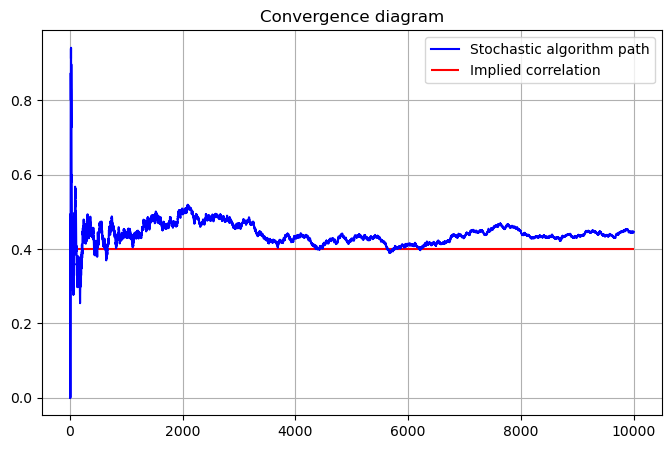

In [55]:
rho_init = 0
batch_size = 1
n_steps = 10000

convergence_diagram(rho_init, batch_size, n_steps)

### L'algorithme stochastique + minibatch

Correlation obtained: 0.4025716205991969


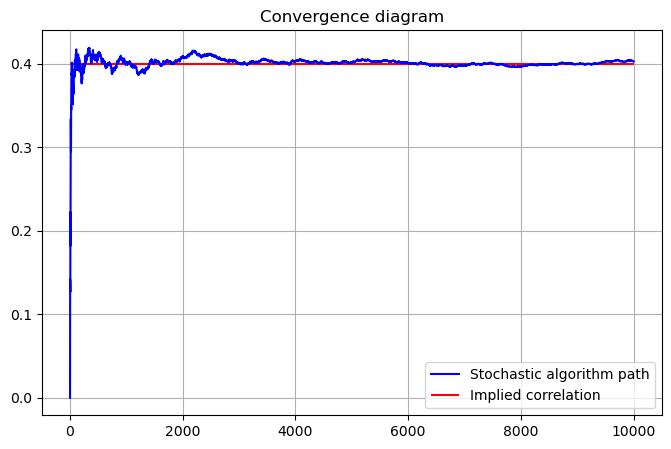

In [56]:
rho_init = 0
batch_size = 50
n_steps = 10000

convergence_diagram(rho_init, batch_size, n_steps)

## Corrélation implicite: approche 2 
$$\rho_n(\theta) = \dfrac{2}{\pi}\arctan(\theta_n)$$
$$
\theta_{n+1} = \theta_n - \gamma_{n+1}H(\rho_n(\theta), Z_{n+1}), \quad \theta_0 = 0.
$$

In [57]:
def convergence_diagram(rho_init, batch_size, n_steps, alpha=0.7):
    def learning_rate(n, alpha=alpha, c=0.05):
        return c / n**alpha
    theta_init = np.tan(np.pi / 2 * rho_init)

    stoch_algo = StochasticOptimisation(
        theta_init=theta_init,
        generate_gradient=lambda batch_size, theta: generate_H(batch_size, 2 / np.pi * np.arctan(theta)),
        learning_rate=learning_rate,
        batch_size=batch_size
    )

    thetas = stoch_algo.step(n_steps=n_steps, return_path=True)
    print('Correlation obtained:', 2 / np.pi * np.arctan(thetas[-1]))

    _, ax = plt.subplots(figsize=(8, 5))

    ax.plot(2 / np.pi * np.arctan(thetas), 'b', label='Stochastic algorithm path')
    ax.hlines(rho, 0, n_steps, color='r', label='Implied correlation')
    ax.set_title('Convergence diagram')
    ax.legend()
    ax.grid()

Correlation obtained: 0.3458084082986096


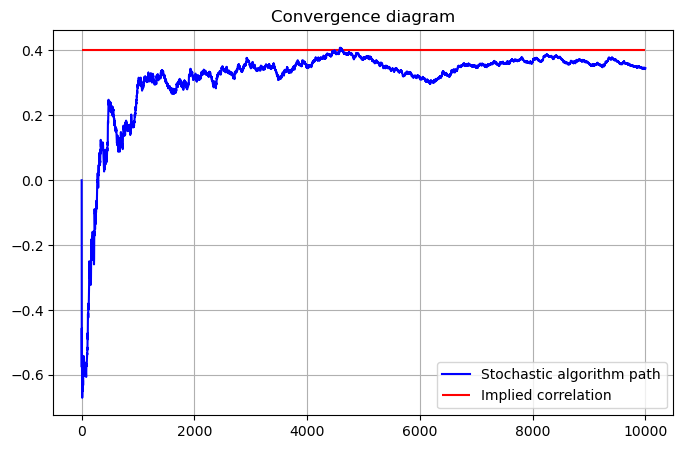

In [58]:
rho_init = 0
batch_size = 1
n_steps = 10000

convergence_diagram(rho_init, batch_size, n_steps)

Correlation obtained: 0.3978655158690339


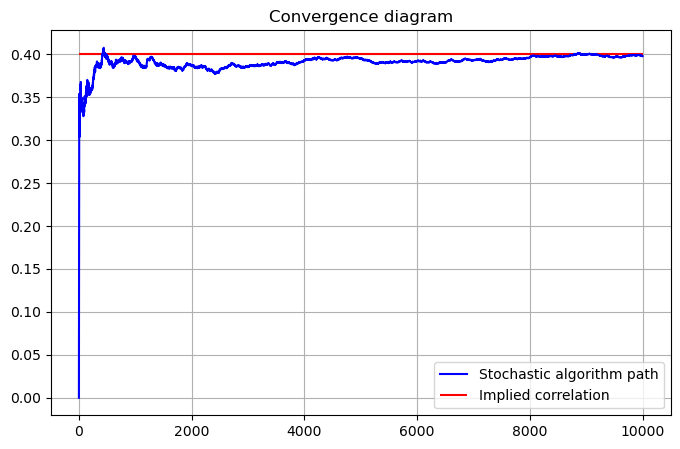

In [60]:
rho_init = 0
batch_size = 50
n_steps = 10000

convergence_diagram(rho_init, batch_size, n_steps)

# III. Calcul de VaR et CVaR

Pour le VaR on cherche le quantile de la loi $F_X$ à l'aide de fonction
$$
V(\xi) = \xi + \dfrac{1}{1-\alpha} \mathbb{E}(Z-\xi)^+, \quad Z \sim F_X, \quad \alpha \in (0, 1)
$$

$VaR$ coppespond à la solution $\xi_L$ de
$$
V'(\xi_\alpha) = 1 - \dfrac{1}{1-\alpha}\mathbb{P}(Z \geq \xi_\alpha) = 0
$$
Méthode de gradient stochastique:
$$
\xi_{n+1} = \xi_n - \gamma_{n+1}\dfrac{\mathbb{I}_{\{Z_{n+1} \leq \xi\}} - \alpha}{1 - \alpha}, \quad Z_n \sim Z \ i.i.d.
$$

### CVaR
On a montré que
$$
\dfrac{1}{n}\sum_{k=0}^{n-1}\left(\xi_k + \dfrac{1}{1-\alpha} (Z_{k+1}-\xi_k)^+\right) \longrightarrow V(\xi_\alpha) = \mathrm{CVaR}_\alpha
$$

## Quantile de la loi de Student

In [100]:
from scipy.stats import t

alpha = 0.95
df=3
q = t.ppf(alpha, df=df)
cvar_mc = np.mean(q + np.maximum(0, rng.standard_t(df=df, size=10**7) - q) / (1 - alpha)) # stupid MC estimator
print(f'Quantile of level {alpha} of the Student distribution:', q)
print(f'Estimated CVaR of level {alpha} of the Student distribution:', cvar_mc)

Quantile of level 0.95 of the Student distribution: 2.3533634348018264
Estimated CVaR of level 0.95 of the Student distribution: 3.872045784159084


In [101]:
rng = np.random.default_rng(seed=42)
cvar = []
def generate_H(batch_size, xi, alpha=alpha):
    Z = rng.standard_t(df=df, size=batch_size)
    cvar.append(np.mean(xi + np.maximum(0, Z - xi) / (1 - alpha)))
    return ((Z <= xi) - alpha) / (1 - alpha)

In [102]:
def convergence_diagram(xi_init, batch_size, n_steps, alpha=0.7):
    def learning_rate(n, alpha=alpha, c=0.5):
        return c / n**alpha
    stoch_algo = StochasticOptimisation(
        theta_init=xi_init,
        generate_gradient=generate_H,
        learning_rate=learning_rate,
        batch_size=batch_size
    )

    thetas = stoch_algo.step(n_steps=n_steps, return_path=True)
    cvars = np.cumsum(np.array(cvar).squeeze()) / np.arange(1, 1 + len(cvar))
    print('VaR obtained:', thetas[-1])
    print('CVaR obtained:', cvars[-1])

    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(thetas, 'b', label='Stochastic algorithm path')
    ax[0].hlines(q, 0, n_steps, color='r', label='Real quantile')
    ax[0].set_title('Convergence diagram (VaR)')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(cvars, 'b', label='Stochastic algorithm path')
    ax[1].hlines(cvar_mc, 0, n_steps, color='r', label='MC estimator')
    ax[1].set_title('Convergence diagram (CVaR)')
    ax[1].legend()
    ax[1].grid()

VaR obtained: 2.250287418823126
CVaR obtained: 4.298501121965751


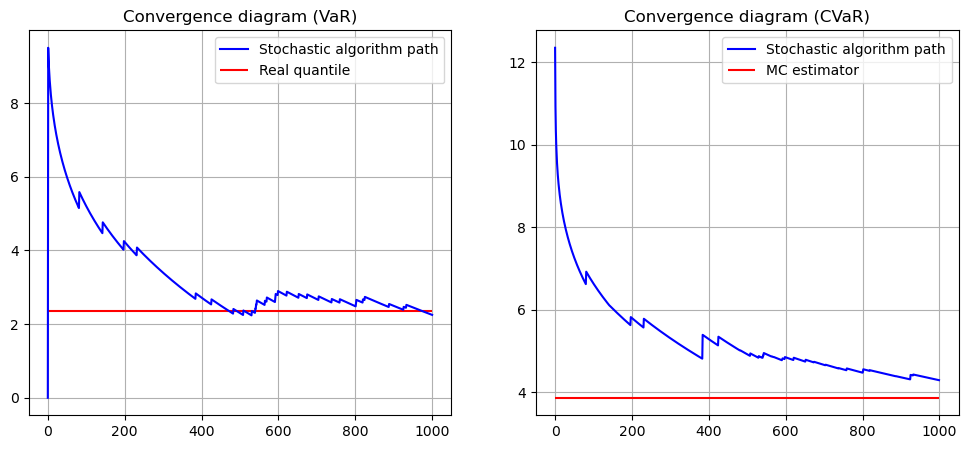

In [103]:
xi_init = 0
batch_size = 1
n_steps = 1000

cvar = []
convergence_diagram(xi_init, batch_size, n_steps)

### Minibatch

VaR obtained: 2.419514775169558
CVaR obtained: 3.906185429402867


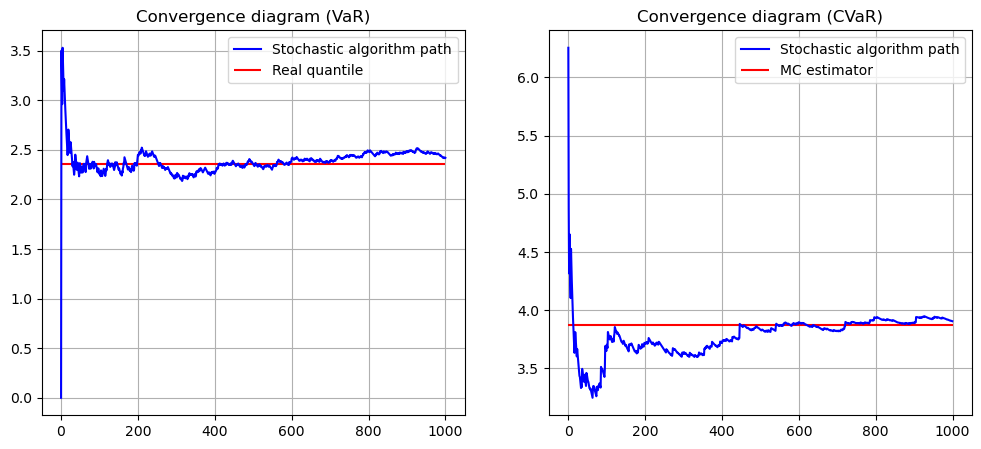

In [104]:
xi_init = 0
batch_size = 10
n_steps = 1000

cvar = []
convergence_diagram(xi_init, batch_size, n_steps)

### Augmentation de $\alpha$ par plateaux

In [105]:
alphas = np.array([0.5, 0.75, 0.8, 0.9, 0.95])
alphas

array([0.5 , 0.75, 0.8 , 0.9 , 0.95])

Chaque valeur $\alpha_k$ s'applique aux itérations $\dfrac{k-1}{10}N, \ldots, \dfrac{k}{10}N - 1$.

In [107]:
def convergence_diagram(xi_init, batch_size, n_steps, alpha=0.6):
    def learning_rate(n, alpha=alpha, c=1):
        return c / n**alpha
    thetas = np.array([xi_init])
    stoch_algo = StochasticOptimisation(
        theta_init=thetas[-1],
        generate_gradient=lambda batch_size, xi: generate_H(batch_size, xi, alphas[0]),
        learning_rate=learning_rate,
        batch_size=batch_size
    )
    for i in range(len(alphas)):
        stoch_algo.generate_gradient = lambda batch_size, xi: generate_H(batch_size, xi, alphas[i])
        thetas_to_add = stoch_algo.step(n_steps=n_steps // len(alphas), return_path=True, reinit_theta=True)
        thetas = np.concatenate([thetas, thetas_to_add])

    print('Quantile obtained:', thetas[-1])

    _, ax = plt.subplots(figsize=(8, 5))

    ax.plot(thetas, 'b', label='Stochastic algorithm path')
    ax.hlines(q, 0, n_steps, color='r', label='Real quantile')
    ax.set_title('Convergence diagram')
    ax.legend()
    ax.grid()

Quantile obtained: 2.452831837418121


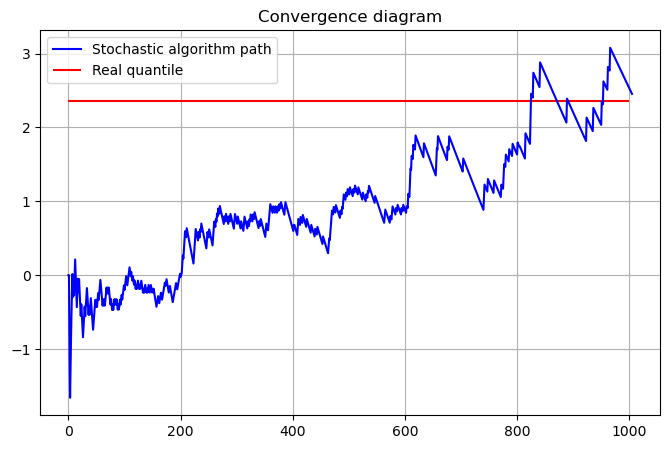

In [108]:
xi_init = 0
batch_size = 1
n_steps = 1000

convergence_diagram(xi_init, batch_size, n_steps)